In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f4536da7-3dfd-63cc-c6c4-668cb659d608)


In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-12 07:33:57--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18407 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.98K  --.-KB/s    in 0.001s  

2022-08-12 07:33:57 (16.6 MB/s) - ‘helper_functions.py’ saved [18407/18407]



In [4]:
from helper_functions import plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix, make_confusion_matrix_for_larger_dataset

In [5]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTE0TF0/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteTE0TF0/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
class_names= ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [9]:
len(class_names)

101

In [10]:
CLASS_COUNT= len(class_names)

In [11]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple, tf.cast() changes the dtype intor float32.

In [12]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
train_data= train_data.map(map_func= preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data= test_data.map(preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data= test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [16]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [17]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

In [18]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [19]:
checkpoint_path= 'checkpoints/feature_extraction'

# Learning Rate Decay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

checkpoint_callback= model_check_point_callback(checkpoint_path, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback= create_tensorboard_callback("transfer_learning", "Food101_full_dataset_feature_extraction")
# Learning Rate Scheduler
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler) 

Saving TensorBoard log files to: transfer_learning/Food101_full_dataset_feature_extraction/20220812-074118


In [20]:
mixed_precision.set_global_policy(policy="mixed_float16")

In [21]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Base Model

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = preprocessing.Rescaling(1./255)(x)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# for layer in model.layers:
#   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
# for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
#   print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [ ]:
# history_101_food_classes_feature_extract = model.fit(train_data, epochs=3,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8230 - accuracy: 0.5577
Epoch 1: val_accuracy improved from -inf to 0.67797, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 217s 83ms/step - loss: 1.8230 - accuracy: 0.5577 - val_loss: 1.2255 - val_accuracy: 0.6780
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6667
Epoch 2: val_accuracy improved from 0.67797 to 0.70869, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 193s 80ms/step - loss: 1.2928 - accuracy: 0.6667 - val_loss: 1.1254 - val_accuracy: 0.7087
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.7014
Epoch 3: val_accuracy did not improve from 0.70869
2368/2368 [==============================] - 174s 73ms/step - loss: 1.1425 - accuracy: 0.7014 - val_loss: 1.0864 - val_accuracy: 0.7071


## Base Model with Dropout layer

> After 10 Epochs

* loss: 1.0400
* accuracy: 0.7157 
* val_loss: 1.0780 
* val_accuracy: 0.7055

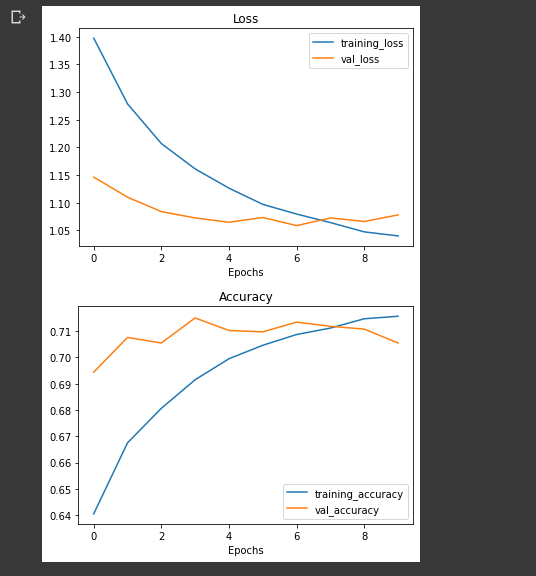

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = preprocessing.Rescaling(1./255)(x)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x=  tf.keras.layers.Dropout(0.2)(x) # Dropout Layer
# x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

In [ ]:
# model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                         

In [ ]:
# history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.3972 - accuracy: 0.6404
Epoch 1: val_accuracy improved from 0.67320 to 0.69439, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 167s 69ms/step - loss: 1.3972 - accuracy: 0.6404 - val_loss: 1.1462 - val_accuracy: 0.6944
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 1.2783 - accuracy: 0.6675
Epoch 2: val_accuracy improved from 0.69439 to 0.70763, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 161s 67ms/step - loss: 1.2783 - accuracy: 0.6675 - val_loss: 1.1100 - val_accuracy: 0.7076
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.2068 - accuracy: 0.6806
Epoch 3: val_accuracy did not improve from 0.70763
2368/2368 [==============================] - 162s 68ms/step - loss: 1.2068 - accuracy: 0.6806 - val_loss: 1.0839 - val_accuracy: 0.7055
Epoch 4/10
2368/2368 [===================

## Base Model With Dropout and Regularization Layer

### After 10 Epochs

* loss: 1.4534
* accuracy: 0.6627
* val_loss: 1.3086
* val_accuracy: 0.6947

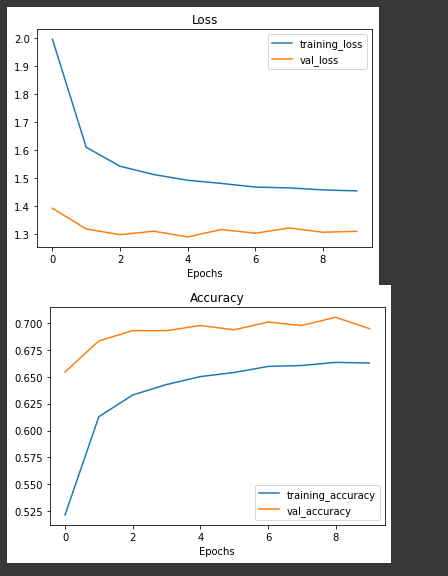

### Fine-Tuning Graph

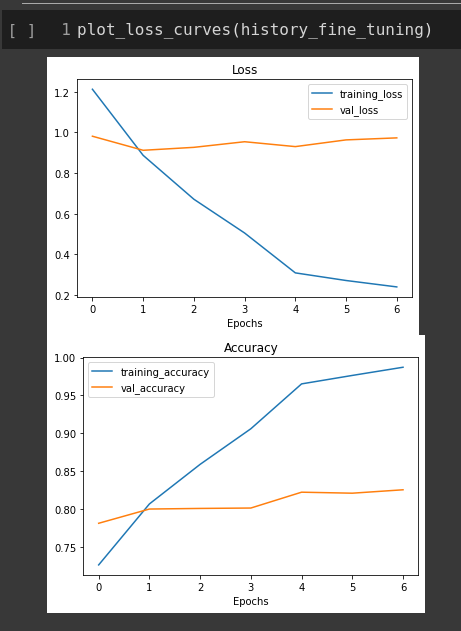

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = preprocessing.Rescaling(1./255)(x)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x=  tf.keras.layers.Dropout(0.2)(x) # Dropout Layer
# x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))(x) # Regularization Layer
# x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 dense_1 (Dense)             (None, 101)               10302     
                                                             

In [ ]:
# history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9965 - accuracy: 0.5216
Epoch 1: val_accuracy improved from -inf to 0.65440, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 195s 74ms/step - loss: 1.9965 - accuracy: 0.5216 - val_loss: 1.3911 - val_accuracy: 0.6544
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 1.6093 - accuracy: 0.6129
Epoch 2: val_accuracy improved from 0.65440 to 0.68326, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 177s 74ms/step - loss: 1.6093 - accuracy: 0.6129 - val_loss: 1.3170 - val_accuracy: 0.6833
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.5417 - accuracy: 0.6330
Epoch 3: val_accuracy improved from 0.68326 to 0.69280, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 167s 70ms/step - loss: 1.5417 - accuracy: 0.6330 - val_loss: 1.2966 - val_accuracy:

## Base Model with Dropout, Regularization and Augmented Layer

### After 10 Epochs


* loss: 1.4529
* accuracy: 0.6640
* val_loss: 1.3060
* val_accuracy: 0.6976


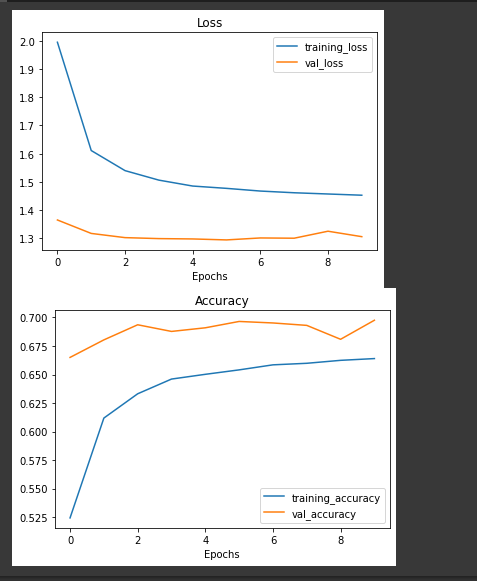

### After Fine-Tuning Model

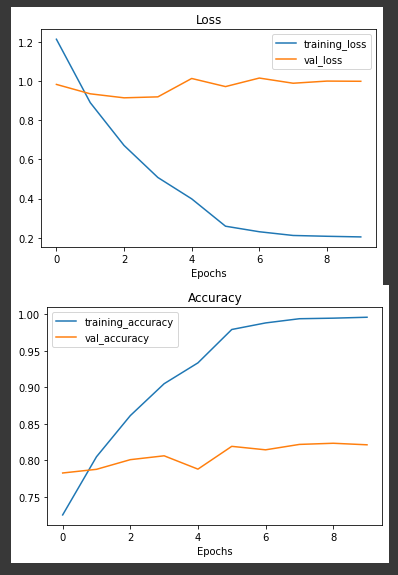

In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = preprocessing.Rescaling(1./255)(x)
# x= augmented_layer(inputs)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x=  tf.keras.layers.Dropout(0.2)(x) # Dropout Layer
# x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))(x) # Regularization Layer
# x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 dense_1 (Dense)             (None, 101)               10302     
                                                             

In [ ]:
# history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9951 - accuracy: 0.5243
Epoch 1: val_accuracy improved from -inf to 0.66499, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 189s 71ms/step - loss: 1.9951 - accuracy: 0.5243 - val_loss: 1.3651 - val_accuracy: 0.6650
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 1.6112 - accuracy: 0.6118
Epoch 2: val_accuracy improved from 0.66499 to 0.68035, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 170s 71ms/step - loss: 1.6112 - accuracy: 0.6118 - val_loss: 1.3174 - val_accuracy: 0.6803
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.5400 - accuracy: 0.6331
Epoch 3: val_accuracy improved from 0.68035 to 0.69359, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 167s 70ms/step - loss: 1.5400 - accuracy: 0.6331 - val_loss: 1.3026 - val_accuracy:

## Base Model with Augmented, Dropout, Regularization layers. Adding `Learning Rate Scheduler`

**Docs** -> https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler

### After 10 Epochs


* loss: 1.3465
* accuracy: 0.6848
* val_loss: 1.2475
* val_accuracy: 0.7076
* lr: 6.0653e-04


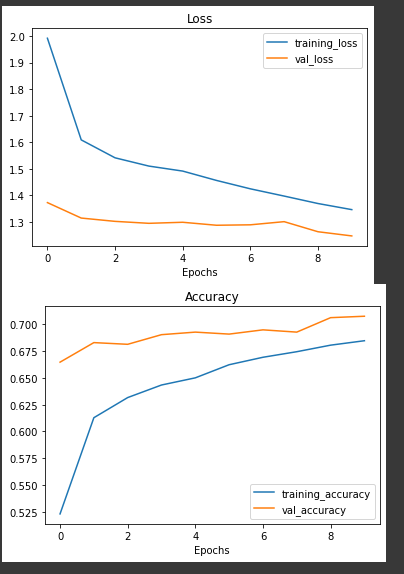


### After Fine-Tuning

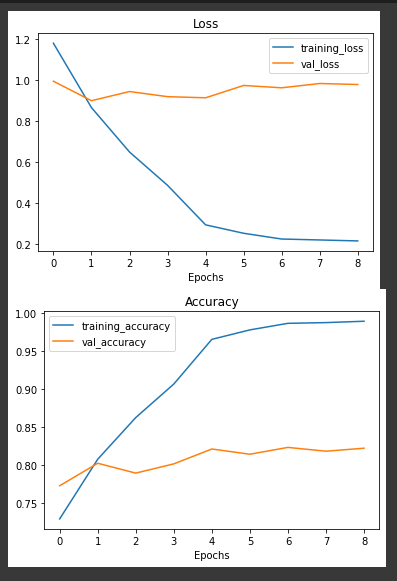



In [ ]:
# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model 
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = preprocessing.Rescaling(1./255)(x)
# x= augmented_layer(inputs)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x=  tf.keras.layers.Dropout(0.2)(x) # Dropout Layer
# x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5))(x) # Regularization Layer
# x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

16719872/16705208 [==============================] - 1s 0us/step


In [ ]:
# model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 dense_1 (Dense)             (None, 101)               10302     
                                                             

In [ ]:
# history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9916 - accuracy: 0.5229
Epoch 1: val_accuracy improved from -inf to 0.66472, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 191s 72ms/step - loss: 1.9916 - accuracy: 0.5229 - val_loss: 1.3729 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.6128
Epoch 2: val_accuracy improved from 0.66472 to 0.68300, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 173s 72ms/step - loss: 1.6090 - accuracy: 0.6128 - val_loss: 1.3147 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 3/10
2367/2368 [============================>.] - ETA: 0s - loss: 1.5415 - accuracy: 0.6317
Epoch 3: val_accuracy did not improve from 0.68300
2368/2368 [==============================] - 165s 69ms/step - loss: 1.5415 - accuracy: 0.6316 - val_loss: 1.3023 - val_accuracy: 0.6814 - lr: 0.0010
Epoch

## Base Model with Augmented, Dropout, Regularization layers. Adding `Learning Rate Decay`. Removing `Learning Rate Scheduler`.



* loss: 1.4543
* accuracy: 0.6616
* val_loss: 1.2963
* val_accuracy: 0.7005



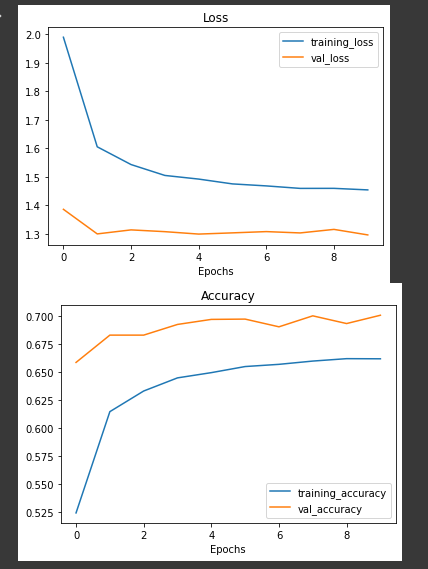


### After Fine-Tuning

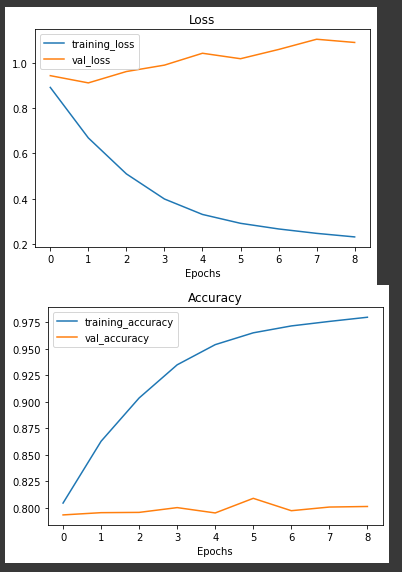


In [22]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs, )
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2, name="Dropout_layer")(x) # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name="regularization_layer")(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(learning_rate= lr_schedule),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [24]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9901 - accuracy: 0.5241
Epoch 1: val_accuracy improved from -inf to 0.65837, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 191s 72ms/step - loss: 1.9901 - accuracy: 0.5241 - val_loss: 1.3862 - val_accuracy: 0.6584
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 1.6056 - accuracy: 0.6144
Epoch 2: val_accuracy improved from 0.65837 to 0.68273, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 171s 71ms/step - loss: 1.6056 - accuracy: 0.6144 - val_loss: 1.2999 - val_accuracy: 0.6827
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.5433 - accuracy: 0.6329
Epoch 3: val_accuracy did not improve from 0.68273
2368/2368 [==============================] - 165s 69ms/step - loss: 1.5433 - accuracy: 0.6329 - val_loss: 1.3140 - val_accuracy: 0.6827
Epoch 4/10
2367/2368 [======================

In [25]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 62ms/step - loss: 1.3036 - accuracy: 0.6984


[1.3035907745361328, 0.6983762383460999]

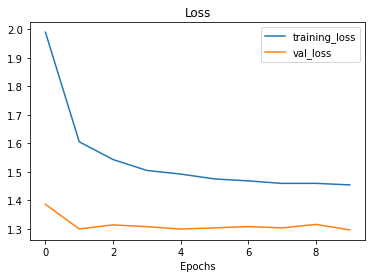

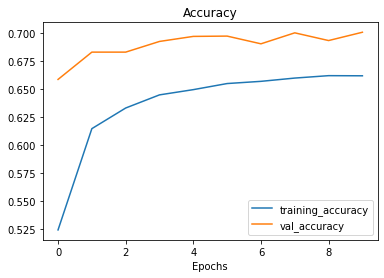

In [26]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [27]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [29]:
cloned_model.load_weights(checkpoint_path)

In [30]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [31]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 50s 61ms/step - loss: 1.9673 - accuracy: 0.5386


In [32]:
results_feature_extract_model == results_cloned_model_with_loaded_weights

False

In [33]:
np.allclose(results_feature_extract_model, results_cloned_model_with_loaded_weights)

False

In [34]:
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [35]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [36]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [37]:
result_loaded_saved_model= loaded_saved_model.evaluate(test_data)
result_loaded_saved_model

790/790 [==============================] - 51s 62ms/step - loss: 1.3036 - accuracy: 0.6984


[1.3035902976989746, 0.6983762383460999]

In [38]:
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [39]:
results_feature_extract_model == result_loaded_saved_model

False

In [40]:
np.allclose(results_feature_extract_model, result_loaded_saved_model)

True

In [41]:
for layer in loaded_saved_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f123ac7c0d0> input_layer True
<keras.engine.functional.Functional object at 0x7f123af3dfd0> efficientnetb0 False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f123bdc0a90> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f123acb0590> Dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f123b01e910> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f123be756d0> dense True
<keras.layers.core.activation.Activation object at 0x7f123b524890> softmax_float32 True


In [42]:
for layer in loaded_saved_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

input_layer float32 <Policy "float32"> True
efficientnetb0 float32 <Policy "mixed_float16"> True
pooling_layer float32 <Policy "mixed_float16"> True
Dropout_layer float32 <Policy "mixed_float16"> True
regularization_layer float32 <Policy "mixed_float16"> True
dense float32 <Policy "mixed_float16"> True
softmax_float32 float32 <Policy "float32"> True


In [43]:
for layer in loaded_saved_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f123b524dd0> input_1 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f1239a56f90> rescaling True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f123ab1e710> normalization True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f123be6d5d0> stem_conv_pad True
<keras.layers.convolutional.Conv2D object at 0x7f1237505ed0> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f123b074310> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f123ab29a50> stem_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f123ab63410> block1a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f123be4c310> block1a_bn True
<keras.layers.core.activation.Activation object at 0x7f123ab8c250> block1a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f123bebde50> block1

In [44]:
for layer in loaded_saved_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [45]:
for layer in loaded_saved_model.layers[1].layers:
  if layer.trainable == True:
    print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f123b524dd0> input_1 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f1239a56f90> rescaling True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f123ab1e710> normalization True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f123be6d5d0> stem_conv_pad True
<keras.layers.convolutional.Conv2D object at 0x7f1237505ed0> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f123b074310> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f123ab29a50> stem_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f123ab63410> block1a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f123be4c310> block1a_bn True
<keras.layers.core.activation.Activation object at 0x7f123ab8c250> block1a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f123bebde50> block1

In [46]:
def scheduler_fine_tuning(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [47]:
checkpoint_path_fine_tuning= 'checkpoints_fine_tuning/fine_tuning'

initial_learning_rate = 0.0001

# Learning Rate Decay
lr_schedule_fine_tuning = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


create_tensorboard_callback_fine_tuning= create_tensorboard_callback("transfer_learning", "fine_tuning_all_data_with_all_layers_unfrozen")
checkpoint_callback_fine_tuning= model_check_point_callback(checkpoint_path_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
early_stopping_callback= create_early_stopping_callback(monitor="val_loss", patience=7)
reduce_lr_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)
lr_scheduler_callback_fine_tuning = tf.keras.callbacks.LearningRateScheduler(scheduler_fine_tuning)

Saving TensorBoard log files to: transfer_learning/fine_tuning_all_data_with_all_layers_unfrozen/20220812-081652


In [48]:
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule_fine_tuning), metrics=["accuracy"])

In [51]:
history_fine_tuning= loaded_saved_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps= int(0.15 * len(test_data)), callbacks=[create_tensorboard_callback_fine_tuning, checkpoint_callback_fine_tuning, early_stopping_callback])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8924 - accuracy: 0.8046
Epoch 1: val_accuracy improved from 0.77172 to 0.79343, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 341s 143ms/step - loss: 0.8924 - accuracy: 0.8046 - val_loss: 0.9443 - val_accuracy: 0.7934
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6688 - accuracy: 0.8629
Epoch 2: val_accuracy improved from 0.79343 to 0.79555, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 339s 142ms/step - loss: 0.6688 - accuracy: 0.8629 - val_loss: 0.9123 - val_accuracy: 0.7956
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.9037
Epoch 3: val_accuracy improved from 0.79555 to 0.79582, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 341s 143ms/step - loss: 0.5098 - accuracy: 0.9037 - val_loss

In [52]:
tf.__version__

'2.8.2'

In [53]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [54]:
result_fine_tuned=loaded_saved_model.evaluate(test_data)
result_fine_tuned

790/790 [==============================] - 51s 64ms/step - loss: 1.1045 - accuracy: 0.7968


[1.1044824123382568, 0.7968316674232483]

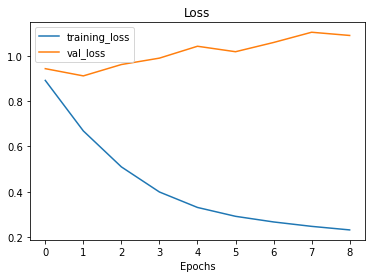

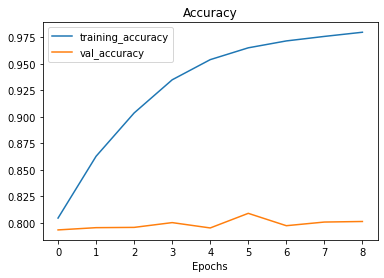

In [55]:
plot_loss_curves(history_fine_tuning)

In [56]:
save_dir = "07_efficientnetb0_fine_tuning_model_mixed_precision"
loaded_saved_model.save(save_dir)

In [57]:
loaded_saved_model_1= tf.keras.models.load_model(save_dir)

In [58]:
result_loaded_saved_model_1= loaded_saved_model_1.evaluate(test_data)
result_loaded_saved_model_1

790/790 [==============================] - 50s 61ms/step - loss: 1.1045 - accuracy: 0.7968


[1.1044838428497314, 0.7968316674232483]

In [59]:
loaded_saved_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 Dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 regularization_layer (Dense  (None, 101)              129381    
 )                                                               
                                                                 
 dense (Dense)               (None, 101)               10302 

In [60]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Fine-Tuning of all 101 classes of Food101 Dataset" \
--description "Transfer Learning on the Food101 dataset with Fine-Tuning the EfficientNetB0 model to beat the 77% accuracy score on DeepFood paper" \
--one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) No


## To-Do

* Fix Overfitting
* Evaluate the model